# Data Preparation & Exploratory Walkthrough

This notebook walks through: loading configuration, reading the dataset, inspecting schema, basic EDA, encoding categorical variables, deterministic splitting, and saving processed artifacts for downstream training.


## Setup & Configuration

We centralize configuration in `params.yaml` and keep paths stable regardless of where the notebook runs from (e.g., inside `notebooks/`).


In [1]:
from pathlib import Path

def find_project_root(start: Path, markers=("params.yaml", ".git")) -> Path:
    """Walk upwards from `start` until we find any of the `markers`.

    Returns the directory containing the marker. Falls back to `start`."""
    start = start.resolve()
    for p in [start, *start.parents]:
        for m in markers:
            if (p / m).exists():
                return p
    return start

# Establish a stable project root for consistent relative paths
CWD = Path.cwd().resolve()
ROOT = find_project_root(CWD)
print("Working directory:", CWD)
print("Project root    :", ROOT)

Working directory: /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/notebooks
Project root    : /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies


In [2]:
import yaml
import pandas as pd

pd.set_option("display.max_columns", 150)
pd.set_option("display.width", 180)

PARAMS_PATH = ROOT / "params.yaml"
if not PARAMS_PATH.exists():
    raise FileNotFoundError(f"Expected params.yaml at {PARAMS_PATH}. Create it before running this notebook.")

with open(PARAMS_PATH, "r") as f:
    params = yaml.safe_load(f)

print("Loaded params:")
params

Loaded params:


{'data': {'raw_csv': 'data/raw/insurance_dataset.csv',
  'target': 'Claim_Amount',
  'test_size': 0.2,
  'random_state': 42}}

**Explanation**  
- We load hyperparameters and data paths from `params.yaml`.  
- This keeps code declarative and lets pipelines (e.g., DVC) change configurations without changing code.


## Load Raw Data

We read the CSV specified in `params.yaml → data.raw_csv` and briefly preview its shape and head.


In [3]:
raw_csv = ROOT / params["data"]["raw_csv"]
target   = params["data"]["target"]
test_size = float(params["data"]["test_size"]) if "test_size" in params.get("data", {}) else 0.2
random_state = int(params["data"]["random_state"]) if "random_state" in params.get("data", {}) else 42

if not raw_csv.exists():
    raise FileNotFoundError(f"Raw CSV not found at {raw_csv}. Ensure your fetch step produced it or adjust params.yaml.")

df = pd.read_csv(raw_csv)
print("Shape:", df.shape)
df.head(10)

Shape: (13000, 7)


,Age,Gender,Income,Marital_Status,Education,Occupation,Claim_Amount
0,59.0,Male,270727.000000,Single,Master's,Doctor,3455.0
1,21.0,Female,263874.000000,Single,Bachelor's,Engineer,30233.0
2,71.0,Female,48372.000000,Single,Bachelor's,Engineer,340.0
3,30.0,Female,99525.000000,Single,PhD,CEO,1002.0
4,64.0,Female,187038.000000,Married,Master's,CEO,2828.0
5,41.0,Female,191551.000000,Married,PhD,CEO,6440.0
6,69.0,Female,43969.000000,Married,PhD,CEO,5964.0
7,61.0,Male,295051.000000,Single,Master's,CEO,8813.0
8,71.0,Female,285444.000000,Married,Master's,CEO,6000.0
9,40.0,Female,404427.908255,Single,Bachelor's,CEO,1127.0


**Output Interpretation**  
- `Shape` shows `(rows, columns)`.  
- The table below previews the first 10 rows for a quick sanity check (column names, obvious data glitches, etc.).


## Schema Inspection

We summarize dtypes, null counts, and cardinality to guide subsequent cleaning and encoding strategies.


In [4]:
df_info = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(t) for t in df.dtypes],
    "nulls": df.isna().sum().values,
    "unique": [df[c].nunique(dropna=True) for c in df.columns],
})
df_info

,column,dtype,nulls,unique
0,Age,float64,0,63
1,Gender,object,0,2
2,Income,float64,0,12087
3,Marital_Status,object,0,2
4,Education,object,0,3
5,Occupation,object,0,5
6,Claim_Amount,float64,0,7728


**Explanation**  
- **dtype** informs numeric vs. categorical handling.  
- **nulls** highlights missing data to impute/drop.  
- **unique** helps spot candidate categoricals (low unique) or IDs (all unique).


## Missing Values Overview

We quantify missingness to decide on imputation or dropping.


In [5]:
missing = df.isna().mean().sort_values(ascending=False).to_frame(name="missing_fraction")
missing.head(20)

,missing_fraction
Age,0.0
Gender,0.0
Income,0.0
Marital_Status,0.0
Education,0.0
Occupation,0.0
Claim_Amount,0.0


**Explanation**  
- Values near `0.0` have little to no missingness; near `1.0` are almost entirely missing.  
- Use this to decide which columns to drop or impute.


## Split Features and Target

We separate `X` and `y` and auto-detect numeric vs categorical features using pandas dtypes.


In [6]:
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in dataset.")

y = df[target].copy()
X = df.drop(columns=[target]).copy()

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

pd.DataFrame({"numeric_columns": num_cols})

Numeric columns: 2
Categorical columns: 4


,numeric_columns
0,Age
1,Income


In [7]:
pd.DataFrame({"categorical_columns": cat_cols})

,categorical_columns
0,Gender
1,Marital_Status
2,Education
3,Occupation


**Explanation**  
- Numeric features typically flow into scaling or tree-based models directly.  
- Categorical features usually need encoding (one-hot, target encoding, embeddings, etc.).


## Target Distribution (If Numeric)

We visualize the target to understand its scale and skew.


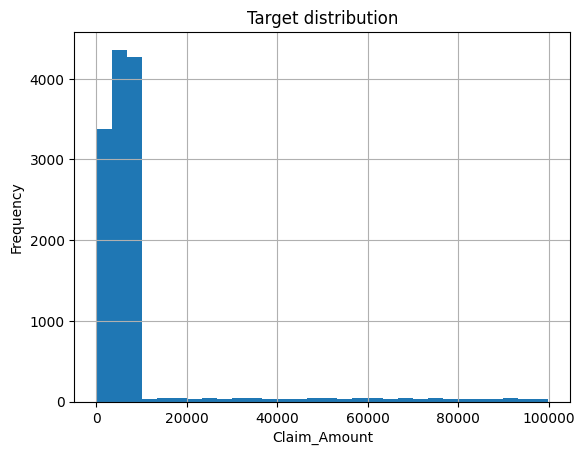

In [8]:
import matplotlib.pyplot as plt

if pd.api.types.is_numeric_dtype(y):
    _ = plt.figure()
    y.hist(bins=30)
    plt.title("Target distribution")
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.show()
else:
    print("Target is non-numeric — skipping histogram.")

**Explanation**  
- Skewed numeric targets may benefit from transformations (e.g., log1p) or robust metrics.


## Categorical Levels Preview

We inspect the most frequent levels of the first few categorical variables to validate assumptions about granularity and noise.


In [9]:
preview_limit = 5
for i, col in enumerate(cat_cols[:preview_limit], start=1):
    print(f"\n[{i}] {col} — top 10 levels")
    display(X[col].astype("category").value_counts().head(10).to_frame(name="count"))


[1] Gender — top 10 levels


,count
Gender,
Female,6541
Male,6459



[2] Marital_Status — top 10 levels


,count
Marital_Status,
Single,6513
Married,6487



[3] Education — top 10 levels


,count
Education,
Master's,4383
PhD,4321
Bachelor's,4296



[4] Occupation — top 10 levels


,count
Occupation,
CEO,10575
Engineer,633
Doctor,624
Waiter,587
Teacher,581


**Explanation**  
- Very high-cardinality categoricals can blow up one-hot encoding; consider hashing or target encoding in such cases.


## Numeric Feature Correlations (Quick Look)

This helps detect redundant features and potential leakage signals.


In [10]:
import numpy as np

num_for_corr = num_cols.copy()
if pd.api.types.is_numeric_dtype(y):
    # Include target for correlation context
    tmp = X[num_for_corr].copy()
    tmp[target] = y
    corr = tmp.corr(numeric_only=True)
else:
    corr = X[num_for_corr].corr(numeric_only=True)

corr

,Age,Income,Claim_Amount
Age,1.00000,-0.001650,0.006490
Income,-0.00165,1.000000,0.024806
Claim_Amount,0.00649,0.024806,1.000000


**Explanation**  
- High correlations (|r| ≳ 0.9) between features can motivate dimensionality reduction or dropping one of the pair for linear models.


## One‑Hot Encoding

We perform a simple one‑hot encoding with `drop_first=True` to avoid perfect collinearity in linear models.


In [11]:
if cat_cols:
    X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)
else:
    X_enc = X.copy()

print("Original X shape:", X.shape)
print("Encoded   X shape:", X_enc.shape)
X_enc.head(10)

Original X shape: (13000, 6)
Encoded   X shape: (13000, 10)


,Age,Income,Gender_Male,Marital_Status_Single,Education_Master's,Education_PhD,Occupation_Doctor,Occupation_Engineer,Occupation_Teacher,Occupation_Waiter
0,59.0,270727.000000,True,True,True,False,True,False,False,False
1,21.0,263874.000000,False,True,False,False,False,True,False,False
2,71.0,48372.000000,False,True,False,False,False,True,False,False
3,30.0,99525.000000,False,True,False,True,False,False,False,False
4,64.0,187038.000000,False,False,True,False,False,False,False,False
5,41.0,191551.000000,False,False,False,True,False,False,False,False
6,69.0,43969.000000,False,False,False,True,False,False,False,False
7,61.0,295051.000000,True,True,True,False,False,False,False,False
8,71.0,285444.000000,False,False,True,False,False,False,False,False
9,40.0,404427.908255,False,True,False,False,False,False,False,False


**Explanation**  
- `drop_first=True` removes one level per categorical to reduce redundancy.  
- Tree-based models don't require scaling, but sparse high-dimensional encodings still impact runtime/memory.


## Deterministic Train/Test Split

We create a reproducible split that respects the configured `test_size` and `random_state`.


In [12]:
Xs = X_enc.sample(frac=1.0, random_state=random_state)
ys = y.loc[Xs.index]

n = len(Xs)
n_test = max(1, int(n * test_size))

X_train = Xs.iloc[:-n_test]
X_test  = Xs.iloc[-n_test:]
y_train = ys.iloc[:-n_test]
y_test  = ys.iloc[-n_test:]

print("X_train:", X_train.shape, " X_test:", X_test.shape)
print("y_train:", y_train.shape, " y_test:", y_test.shape)

display(X_train.head(5))
display(y_train.head(5).to_frame(name=target))

X_train: (10400, 10)  X_test: (2600, 10)
y_train: (10400,)  y_test: (2600,)


,Age,Income,Gender_Male,Marital_Status_Single,Education_Master's,Education_PhD,Occupation_Doctor,Occupation_Engineer,Occupation_Teacher,Occupation_Waiter
3615,46.0,296112.0,False,False,False,True,False,False,False,False
2536,65.0,274007.0,False,True,True,False,False,False,True,False
5397,56.0,48050.0,True,False,False,False,False,True,False,False
9982,59.0,174748.0,False,False,False,True,False,False,False,False
1498,51.0,246132.0,False,False,True,False,False,False,False,False


,Claim_Amount
3615,62237.0
2536,26590.0
5397,5257.0
9982,3032.0
1498,5970.0


**Explanation**  
- We shuffle deterministically and slice off the last `n_test` rows for testing.  
- This avoids leakage from any time ordering only if your data is i.i.d. If time-ordered, use time-based splits instead.


## Save Processed Artifacts

We persist train/test splits and a simple schema file for downstream training and model serving steps.


In [13]:
import json

out_dir = ROOT / "data" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)

X_train.to_csv(out_dir / "X_train.csv", index=False)
X_test.to_csv(out_dir / "X_test.csv", index=False)
y_train.to_csv(out_dir / "y_train.csv", index=False)
y_test.to_csv(out_dir / "y_test.csv", index=False)

schema = {
    "target": target,
    "original_num_cols": num_cols,
    "original_cat_cols": cat_cols,
    "encoded_feature_columns": list(X_enc.columns),
}
(out_dir / "schema.json").write_text(json.dumps(schema, indent=2))

print("Wrote:")
for name in ["X_train.csv", "X_test.csv", "y_train.csv", "y_test.csv", "schema.json"]:
    print("-", out_dir / name)

Wrote:
- /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/data/processed/X_train.csv
- /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/data/processed/X_test.csv
- /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/data/processed/y_train.csv
- /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/data/processed/y_test.csv
- /Users/chaitanyamalani/Desktop/CMN/Study/Projects/insurance_policies/data/processed/schema.json


**Explanation**  
- Saving consistent artifacts allows downstream scripts (training/serving) and experiments (MLflow runs) to consume the exact same inputs.  
- `schema.json` captures feature engineering state for reproducible inference.


## Next Steps

- Add a training script that reads `data/processed/*` and logs experiments to MLflow.  
- Consider DVC stages for `fetch → prepare → train → evaluate`.  
- For productionization, replace one‑hot with a `ColumnTransformer` pipeline and persist it alongside the model.
